In [82]:
pip install py2neo pandas matplotlib sklearn

Note: you may need to restart the kernel to use updated packages.


In [83]:
from py2neo import Graph

In [186]:
import pandas as pd

import matplotlib 
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import pandas as pd
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

In [115]:
graph = Graph("bolt://localhost:7687", auth=("neo4j", "1234"))

In [86]:
#DataLoading Create Nodes
display(graph.run("CREATE CONSTRAINT ON (a:Article) ASSERT a.index IS UNIQUE").stats())
display(graph.run("CREATE CONSTRAINT ON (a:Author) ASSERT a.name IS UNIQUE").stats())
display(graph.run("CREATE CONSTRAINT ON (v:Venue) ASSERT v.name IS UNIQUE").stats())

constraints_added: 1
constraints_removed: 0
contained_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 0
relationships_created: 0
relationships_deleted: 0

constraints_added: 1
constraints_removed: 0
contained_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 0
relationships_created: 0
relationships_deleted: 0

constraints_added: 1
constraints_removed: 0
contained_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 0
relationships_created: 0
relationships_deleted: 0

In [87]:
query = """
CALL apoc.periodic.iterate(
  'UNWIND ["dblp-ref-0.json", "dblp-ref-1.json", "dblp-ref-2.json", "dblp-ref-3.json"] AS file
   CALL apoc.load.json("https://github.com/neo4j-contrib/training-v3/raw/master/modules/gds-data-science/supplemental/data/" + file)
   YIELD value WITH value
   return value',
  'MERGE (a:Article {index:value.id})
   SET a += apoc.map.clean(value,["id","authors","references", "venue"],[0])
   WITH a, value.authors as authors, value.references AS citations, value.venue AS venue
   MERGE (v:Venue {name: venue})
   MERGE (a)-[:VENUE]->(v)
   FOREACH(author in authors | 
     MERGE (b:Author{name:author})
     MERGE (a)-[:AUTHOR]->(b))
   FOREACH(citation in citations | 
     MERGE (cited:Article {index:citation})
     MERGE (a)-[:CITED]->(cited))', 
   {batchSize: 1000, iterateList: true});
"""
graph.run(query).to_data_frame()

,batches,total,timeTaken,committedOperations,failedOperations,failedBatches,retries,errorMessages,batch,operations,wasTerminated,failedParams,updateStatistics
0,52,51956,27,51956,0,0,0,{},"{'total': 52, 'committed': 52, 'failed': 0, 'e...","{'total': 51956, 'committed': 51956, 'failed':...",False,{},"{'nodesDeleted': 0, 'labelsAdded': 264616, 're..."


In [88]:
#delete all Article nodes that have no title
query = """
MATCH (a:Article) WHERE not(exists(a.title))
DETACH DELETE a
"""
graph.run(query).stats()

constraints_added: 0
constraints_removed: 0
contained_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 132357
properties_set: 0
relationships_created: 0
relationships_deleted: 261202

In [89]:
#labels: Venue, Author, Article

graph.run("CALL db.schema.visualization()").data()

[{'nodes': [Node('Venue', constraints=["Constraint( id=6, name='constraint_ae6d9b7b', type='UNIQUENESS', schema=(:Venue {name}), ownedIndex=5 )"], indexes=[], name='Venue'),
   Node('Article', constraints=["Constraint( id=2, name='constraint_2e688049', type='UNIQUENESS', schema=(:Article {index}), ownedIndex=1 )"], indexes=[], name='Article'),
   Node('Author', constraints=["Constraint( id=4, name='constraint_293d3e9e', type='UNIQUENESS', schema=(:Author {name}), ownedIndex=3 )"], indexes=[], name='Author')],
  'relationships': [VENUE(Node(), Node()),
   AUTHOR(Node(), Node()),
   CITED(Node(), Node())]}]

In [90]:
#How many nodes  for each of these labels Venue, Author and Article
result = {"label": [], "count": []}
for label in graph.run("CALL db.labels()").to_series():
    query = f"MATCH (:`{label}`) RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["label"].append(label)
    result["count"].append(count)
nodes_df = pd.DataFrame(data=result)
nodes_df.sort_values("count")

,label,count
2,Venue,4
0,Article,51956
1,Author,80299


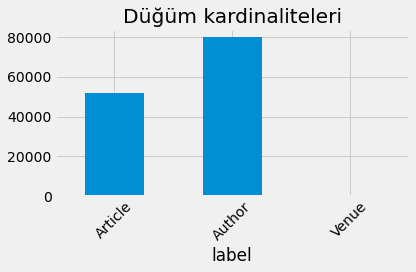

In [91]:
#visualize the counts using matplotlib
nodes_df.plot(kind='bar', x='label', y='count', legend=None, title="Düğüm kardinaliteleri")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [92]:
#What types of relationships in Graph (CITED, VENUE, AUTHOR)

result = {"relType": [], "count": []}
for relationship_type in graph.run("CALL db.relationshipTypes()").to_series():
    query = f"MATCH ()-[:`{relationship_type}`]->() RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["relType"].append(relationship_type)
    result["count"].append(count)
rels_df = pd.DataFrame(data=result)
rels_df.sort_values("count")

,relType,count
2,CITED,28706
0,VENUE,51956
1,AUTHOR,140575


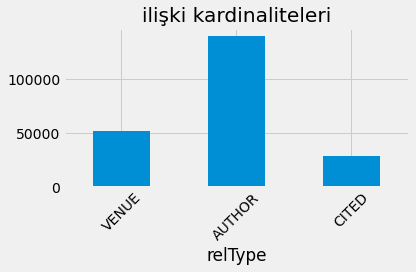

In [93]:
rels_df.plot(kind='bar', x='relType', y='count', legend=None, title="ilişki kardinaliteleri")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [94]:
#25 Yazar, Makale, Dergi için Makalelerin alıntı yaptığı makale sayısının yanı sıra 
#alıntılandığı makale sayısını da gösterir.

exploratory_query = """
MATCH (author:Author)<-[:AUTHOR]-(article:Article)-[:VENUE]->(venue)
RETURN article.title AS article, author.name AS author, venue.name AS venue, 
       size((article)-[:CITED]->()) AS citationsGiven, size((article)<-[:CITED]-()) AS citationsReceived
ORDER BY rand()
LIMIT 25
"""

graph.run(exploratory_query).to_data_frame()

,article,author,venue,citationsGiven,citationsReceived
0,LASE: locating and applying systematic edits b...,Miryung Kim,international conference on software engineering,5,7
1,LASE: locating and applying systematic edits b...,Na Meng,international conference on software engineering,5,7
2,LASE: locating and applying systematic edits b...,Kathryn S. McKinley,international conference on software engineering,5,7
3,Simulated annealing genetic algorithm for surf...,Jinxiang Dong,Lecture Notes in Computer Science,0,1
4,Simulated annealing genetic algorithm for surf...,Min Tang,Lecture Notes in Computer Science,0,1
5,Learning face localization using hierarchical ...,Sven Behnke,Lecture Notes in Computer Science,0,0
6,Monitoring-Based Dynamic Relocation of Compone...,Israel Ben-Shaul,Lecture Notes in Computer Science,1,1
7,Monitoring-Based Dynamic Relocation of Compone...,Ophir Holder,Lecture Notes in Computer Science,1,1
8,Monitoring-Based Dynamic Relocation of Compone...,Hovav Gazit,Lecture Notes in Computer Science,1,1
9,Analysis and interpretation of multiple motion...,Mircea Nicolescu,Lecture Notes in Computer Science,0,0


In [95]:
#Her makalenin sahip olduğu alıntıların sayısını döndüren ve ardından pandas kütüphanesinin açıklama fonksiyonu kullanarak
#bu sayıların bir dağılımını oluşturan sorgu:
#Çoğu makaleye çok az atıf yapılmaktadır. Makalelerin %99'unda 8 veya daha az atıf vardır. 
#Ancak bir makaleye 200'den fazla atıf yapıldığı görülmektedir.

query = """
MATCH (a:Article)
RETURN size((a)<-[:CITED]-()) AS citations
"""

citation_df = graph.run(query).to_data_frame()
citation_df.describe([.25, .5, .75, .9, .99])

,citations
count,51956.000
mean,0.553
std,2.418
min,0.000
25%,0.000
50%,0.000
75%,0.000
90%,1.000
99%,8.000
max,211.000


In [96]:
#Diğer makalelere kıyasla daha fazla alıntı yapan makalelerin sayısı aşağıdaki gibidir:
query = """
MATCH (a:Article)
RETURN size((a)-[:CITED]->()) AS cited
"""

cited_df = graph.run(query).to_data_frame()
cited_df.describe([.25, .5, .75, .9, .99])

,cited
count,51956.000
mean,0.553
std,1.301
min,0.000
25%,0.000
50%,0.000
75%,1.000
90%,2.000
99%,6.000
max,51.000


In [97]:
#Yazarlar tarafından yayınlanan makale sayısının dağılımı
query = """
MATCH (a:Author)
RETURN size((a)<-[:AUTHOR]-()) AS published
"""

published_df = graph.run(query).to_data_frame()
published_df.describe([.25, .5, .75, .9, .99])

,published
count,80299.000
mean,1.751
std,2.064
min,1.000
25%,1.000
50%,1.000
75%,2.000
90%,3.000
99%,10.000
max,89.000


In [98]:
#En çok makale yazan popüler yazarlar
popular_authors_query = """
MATCH (author:Author)
RETURN author.name, size((author)<-[:AUTHOR]-()) AS articlesPublished
ORDER BY articlesPublished DESC
LIMIT 10
"""

graph.run(popular_authors_query).to_data_frame()

,author.name,articlesPublished
0,Peter G. Neumann,89
1,Peter J. Denning,80
2,Moshe Y. Vardi,72
3,Pamela Samuelson,71
4,Bart Preneel,65
5,Vinton G. Cerf,56
6,Barry W. Boehm,53
7,Mark Guzdial,49
8,Edwin R. Hancock,47
9,Josef Kittler,46


In [99]:
#Bu yazarlardan ilkinin yayınladığı makalelerden 20 tanesinin kaç atıf aldığı:
author_name = "Peter G. Neumann"
author_articles_query = """
MATCH (:Author {name: $authorName})<-[:AUTHOR]-(article)
RETURN article.title AS article, article.year AS year, size((article)<-[:CITED]-()) AS citations
ORDER BY citations DESC
LIMIT 20
"""

graph.run(author_articles_query,  {"authorName": author_name}).to_data_frame()

,article,year,citations
0,Security by obscurity,2003,2
1,"The foresight saga, redux",2012,2
2,Risks of automation: a cautionary total-system...,2016,1
3,Robust open-source software,1999,1
4,Are dependable systems feasible,1993,1
5,Crypto policy perspectives,1994,1
6,Risks of National Identity Cards,2001,1
7,Information system security redux,2003,1
8,The foresight saga,2006,1
9,"Computers, ethics, and values",1991,1


In [100]:
#Bu yazarın ortak makale yaptığı 10 yazar
collaborations_query = """
MATCH (:Author {name: $authorName})<-[:AUTHOR]-(article)-[:AUTHOR]->(coauthor)
RETURN coauthor.name AS coauthor, count(*) AS collaborations
ORDER BY collaborations DESC
LIMIT 10
"""

graph.run(collaborations_query,  {"authorName": author_name}).to_data_frame()

,coauthor,collaborations
0,Susan Landau,3
1,Lauren Weinstein,3
2,Whitfield Diffie,3
3,Steven Michael Bellovin,2
4,Rebecca T. Mercuri,2
5,Matt Blaze,2
6,Herbert S. Lin,1
7,Alfred Z. Spector,1
8,David Lorge Parnas,1
9,Lawrence Robinson,1


In [101]:
#Bu yazar için gelecekte yapacağı çalışmalarda hangi yazarlarla ortak çalışması gerektiği nasıl önerilir?
#Bunun bir yolu ortak çalışılan yazarların diğer ortak çalıştığı yazarlara bakmaktır.

collaborations_query = """
MATCH (author:Author {name: $authorName})<-[:AUTHOR]-(article)-[:AUTHOR]->(coauthor),
      (coauthor)<-[:AUTHOR]-()-[:AUTHOR]->(coc)
WHERE not((coc)<-[:AUTHOR]-()-[:AUTHOR]->(author)) AND coc <> author      
RETURN coc.name AS coauthor, count(*) AS collaborations
ORDER BY collaborations DESC
LIMIT 10
"""

graph.run(collaborations_query,  {"authorName": author_name}).to_data_frame()

,coauthor,collaborations
0,John Ioannidis,10
1,Scott Bradner,9
2,Angelos D. Keromytis,8
3,John Kelsey,7
4,Virgil D. Gligor,5
5,Ran Canetti,4
6,Peter Wolcott,4
7,William Aiello,4
8,David K. Gifford,4
9,Gerald Jay Sussman,4


In [102]:
#'Brian Fitzgerald' için önerilen en iyi 20 ortak çalışan
query = """
MATCH (author:Author {name: $authorName})<-[:AUTHOR]-(article)-[:AUTHOR]->(coauthor),
      (coauthor)<-[:AUTHOR]-()-[:AUTHOR]->(coc)
WHERE not((coc)<-[:AUTHOR]-()-[:AUTHOR]->(author)) AND coc <> author      
RETURN coc.name AS coauthor, count(*) AS collaborations
ORDER BY collaborations DESC
LIMIT 20
"""

params = {"authorName": "Brian Fitzgerald", "searchTerm": "open source"}
graph.run(query, params).to_data_frame()

,coauthor,collaborations
0,Holger Giese,5
1,Grace A. Lewis,4
2,Robert C. Seacord,4
3,Gabriel A. Moreno,4
4,Kurt C. Wallnau,4
5,Chris Jensen,4
6,Judith A. Stafford,4
7,Thomas D. LaToza,3
8,Klaus Pohl,3
9,Gerald Bortis,3


In [103]:
#Bu potansiyel işbirlikçilerden kaç tanesi Brian'ın işbirlikçileriyle 3 defadan fazla iş birliği yapmıştır?
query = """
MATCH (author:Author {name: $authorName})<-[:AUTHOR]-(article)-[:AUTHOR]->(coauthor),
      (coauthor)<-[:AUTHOR]-()-[:AUTHOR]->(coc)
WHERE not((coc)<-[:AUTHOR]-()-[:AUTHOR]->(author)) AND coc <> author      
WITH coc, count(*) AS collaborations
WHERE collaborations > 3
RETURN count(*) as count
"""
graph.run(query, params).to_data_frame()

,count
0,7


In [104]:
#PageRank, düğümlerin geçişli etkisini veya bağlanabilirliğini ölçen bir algoritmadır.
#Bir düğümün sırasını (başlangıçta dereceye dayalı olarak) komşuları üzerinde yinelemeli olarak dağıtır veya
#grafiği rastgele çaprazlayarak, düğümlere üzerindeki ilerleme sırasında bir düğümün çarpma sıklığını sayarak 
#hesaplama yapar.
#Alıntılar göz önüne alınarak, en popüler makaleyi bulmak için pagerank algoritması tüm grafik üzerinde çalıştırılır.

query = """
CALL gds.pageRank.write({
  nodeProjection:'Article', 
  relationshipProjection:'CITED',
  writeProperty:'pagerank'})
"""
graph.run(query).data()

[{'writeMillis': 551,
  'nodePropertiesWritten': 51956,
  'ranIterations': 20,
  'didConverge': False,
  'centralityDistribution': {'p99': 1.3121633529663086,
   'min': 0.14999961853027344,
   'max': 93.94335842132568,
   'mean': 0.22228103071687513,
   'p90': 0.2774991989135742,
   'p50': 0.14999961853027344,
   'p999': 5.657378196716309,
   'p95': 0.43799686431884766,
   'p75': 0.14999961853027344},
  'postProcessingMillis': 95,
  'createMillis': 237,
  'computeMillis': 2300,
  'configuration': {'maxIterations': 20,
   'writeConcurrency': 4,
   'relationshipWeightProperty': None,
   'cacheWeights': False,
   'concurrency': 4,
   'sourceNodes': [],
   'writeProperty': 'pagerank',
   'nodeLabels': ['*'],
   'sudo': False,
   'dampingFactor': 0.85,
   'relationshipTypes': ['*'],
   'tolerance': 1e-07}}]

In [105]:
#Her bir düğümde bir pagerank özelliği saklıdır. 
#Bu özelliklere göre makalelere bir skor atanır.
#En popüler makalelerden 10 tanesi skor sıralamasına göre aşağıdaki gibidir:
query = """
MATCH (a:Article)
RETURN a.title as article,
       a.pagerank as score
ORDER BY score DESC 
LIMIT 10
"""
graph.run(query).to_data_frame()

,article,score
0,A method for obtaining digital signatures and ...,93.943
1,Secure communications over insecure channels,79.869
2,Rough sets,25.609
3,An axiomatic basis for computer programming,23.029
4,"Pastry: Scalable, Decentralized Object Locatio...",21.470
5,SCRIBE: The Design of a Large-Scale Event Noti...,19.486
6,A field study of the software design process f...,19.028
7,Productivity factors and programming environments,18.499
8,Analyzing medium-scale software development,16.453
9,A Calculus of Communicating Systems,15.431


In [106]:
#Kişiselleştirilmiş PageRank, bir dizi kaynak düğüme dayalı olarak 
#etkili düğümleri bulmamıza izin veren bir PageRank çeşididir.
#Örneğin, genel olarak en etkili makaleleri bulmak yerine, belirli bir yazara göre en etkili makaleleri bulabiliriz.
#Peter G. Neumann'ın en etkili makalelerinden 10 tanesi aşağıdaki gibidir.
query = """
MATCH (a:Author {name: $author})<-[:AUTHOR]-(article)-[:CITED]->(other)
WITH collect(article) + collect(other) AS sourceNodes
CALL gds.pageRank.stream({
  nodeProjection:'Article',
  relationshipProjection:'CITED',
  sourceNodes: sourceNodes})
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).title AS article, score
ORDER BY score DESC
LIMIT 10
"""

author_name = "Peter G. Neumann"
graph.run(query, {"author": author_name}).to_data_frame()

,article,score
0,A technique for software module specification ...,0.359
1,A messy state of the union: taming the composi...,0.332
2,Public interest and the NII,0.278
3,Risks of e-voting,0.278
4,Password security: a case history,0.278
5,Risks of automation: a cautionary total-system...,0.278
6,Crypto policy perspectives,0.278
7,The foresight saga,0.278
8,The challenges of partially automated driving,0.268
9,Proof techniques for hierarchically structured...,0.248


In [107]:
#Konuya göre en etkili makaleleri bulmak için de kişiselleştirilmiş PageRank Kullanılabilir:
#Bir yazar okunacak makale konusu ararken, bu aramanın kendini yazar olarak hesaba katmasını ister. 
#Aynı arama terimini kullanan iki yazar, araştırma alanlarına bağlı olarak farklı sonuçlar görmeyi bekleyecektir.
query = """
    CALL db.index.fulltext.createNodeIndex('articles', ['Article'], ['title', 'abstract'])
"""
graph.run(query).data()

[]

In [108]:
query = """
CALL db.indexes()
YIELD name, state, populationPercent, uniqueness, type, entityType, labelsOrTypes, properties, provider
WHERE type = "FULLTEXT"
RETURN *
"""
graph.run(query).to_data_frame()

,entityType,labelsOrTypes,name,populationPercent,properties,provider,state,type,uniqueness
0,NODE,[Article],articles,100.000,"[title, abstract]",fulltext-1.0,ONLINE,FULLTEXT,NONUNIQUE


In [109]:
query = """
CALL db.index.fulltext.queryNodes("articles", "open source")
YIELD node, score
RETURN node.title as article, score, [(author)<-[:AUTHOR]-(node) | author.name] AS authors
LIMIT 10
"""
graph.run(query).to_data_frame()

,article,score,authors
0,Progressive open source,11.740,"[Jamie Dinkelacker, Pankaj K. Garg, Dean Nelso..."
1,Open source application spaces: the 5th worksh...,11.150,"[Joseph Feller, Scott A. Hissam, Brian Fitzger..."
2,Reusing Open-Source Software and Practices: Th...,11.016,"[Alan W. Brown, Grady Booch]"
3,From Research Software to Open Source,10.328,[Susan L. Graham]
4,The comment density of open source software code,10.292,"[Oliver Arafati, Dirk Riehle]"
5,Software architecture in an open source world,10.250,[Roy T. Fielding]
6,Managing a corporate open source software asset,10.187,"[James D. Herbsleb, Vijay K. Gurbani, Anita Ga..."
7,Organizational adoption of open source softwar...,9.894,"[Anol Bhattacherjee, Areej M. Yassin, Del Nagy]"
8,IBM's pragmatic embrace of open source,9.849,[Pamela Samuelson]
9,Analysing the reliability of Open Source softw...,9.683,"[Lerina Aversano, Maria Tortorella]"


In [110]:
#'Açık kaynak' hakkında en çok makale yayınlayan yazarları bulmak için:
query = """
CALL db.index.fulltext.queryNodes("articles", "open source")
YIELD node, score
MATCH (node)-[:AUTHOR]->(author)
RETURN author.name as author, sum(score) AS totalScore, collect(node.title) AS articles
ORDER By totalScore DESC
LIMIT 20
"""

graph.run(query).to_data_frame()

,author,totalScore,articles
0,Denys Poshyvanyk,51.326,[Machine learning-based detection of open sour...
1,Brian Fitzgerald,49.406,[Open source application spaces: the 5th works...
2,Joseph Feller,45.596,[Open source application spaces: the 5th works...
3,James D. Herbsleb,38.699,[Managing a corporate open source software ass...
4,Gail C. Murphy,36.538,"[Who should fix this bug, Hipikat: recommendin..."
5,Walt Scacchi,34.336,[Open source application spaces: the 5th works...
6,Ahmed E. Hassan,33.800,[A study of the quality-impacting practices of...
7,Daniel M. German,33.478,[Machine learning-based detection of open sour...
8,Martin P. Robillard,33.017,[Disseminating architectural knowledge on open...
9,Scott A. Hissam,32.555,[Open source application spaces: the 5th works...


In [111]:
#Ardından, farklı yazarlar için ilginç makaleler bulmak amacıyla tam metin araması ve Kişiselleştirilmiş PageRank
#kullanılır.

query = """
MATCH (a:Author {name: $author})<-[:AUTHOR]-(article)-[:CITED]->(other)
WITH a, collect(article) + collect(other) AS sourceNodes
CALL gds.pageRank.stream({
  nodeQuery: 'CALL db.index.fulltext.queryNodes("articles", $searchTerm)
   YIELD node, score
   RETURN id(node) as id',
  relationshipQuery: 'MATCH (a1:Article)-[:CITED]->(a2:Article) 
   RETURN id(a1) as source,id(a2) as target', 
  sourceNodes: sourceNodes,
  validateRelationships:false,
  parameters: {searchTerm: $searchTerm}})
YIELD nodeId, score
WITH gds.util.asNode(nodeId) AS n, score
WHERE not(exists((a)<-[:AUTHOR]-(n))) AND score > 0
RETURN n.title as article, score, [(n)-[:AUTHOR]->(author) | author.name][..5] AS authors
order by score desc limit 10
"""

params = {"author": "Tao Xie", "searchTerm": "open source"}
graph.run(query, params).to_data_frame()

,article,score,authors
0,Static detection of cross-site scripting vulne...,0.386,"[Zhendong Su, Gary Wassermann]"
1,Who should fix this bug,0.278,"[Gail C. Murphy, John Anvik, Lyndon Hiew]"
2,"Automated, contract-based user testing of comm...",0.278,"[Yvan Labiche, Michal M. Sówka, Lionel C. Briand]"
3,Concern graphs: finding and describing concern...,0.278,"[Martin P. Robillard, Gail C. Murphy]"
4,Characterizing logging practices in open-sourc...,0.278,"[Yuanyuan Zhou, Ding Yuan, Soyeon Park]"
5,Conceptual module querying for software reengi...,0.236,"[Elisa L. A. Baniassad, Gail C. Murphy]"
6,Bandera: extracting finite-state models from J...,0.150,"[James C. Corbett, Shawn Laubach, John Hatclif..."
7,AsDroid: detecting stealthy behaviors in Andro...,0.150,"[Xiangyu Zhang, Bin Liang, Jianjun Huang, Lin ..."
8,Semantics-based code search,0.150,[Steven P. Reiss]
9,EXSYST: search-based GUI testing,0.128,"[Gordon Fraser, Florian Gross, Andreas Zeller]"


In [112]:
#Aynı sorgu farklı bir yazar için çalışıtırılırsa:
params = {"author": "Marco Aurélio Gerosa", "searchTerm": "open source"}
graph.run(query, params).to_data_frame()

,article,score,authors
0,Toward an understanding of the motivation of o...,0.388,"[Yunwen Ye, Kouichi Kishida]"
1,Hipikat: recommending pertinent software devel...,0.322,"[Gail C. Murphy, Davor Cubranic]"
2,Version Sensitive Editing: Change History as a...,0.274,[David L. Atkins]
3,Which bug should I fix: helping new developers...,0.239,"[Jianguo Wang, Anita Sarma]"
4,Tesseract: Interactive visual exploration of s...,0.203,"[Patrick Wagstrom, Larry Maccherone, James D. ..."
5,Role Migration and Advancement Processes in OS...,0.175,"[Chris Jensen, Walt Scacchi]"
6,Does the initial environment impact the future...,0.175,"[Audris Mockus, Minghui Zhou]"
7,Unifying artifacts and activities in a visual ...,0.173,"[Jon Froehlich, Paul Dourish]"
8,A case study of open source software developme...,0.110,"[Audris Mockus, James D. Herbsleb, Roy Fielding]"
9,A case study of the evolution of Jun: an objec...,0.110,"[A. Takasbima, Kouichi Kishida, Yoshiyuki Nish..."


In [113]:
#Aynı makaleler üzerinde çalışan kişilere bağlı olarak ortak yazarların bir grafiği çıkarılır.
#Ortak çalışmalarının hangi yılda olduğunu gösteren ilişki üzerinde bir özellik depolaması yapılacaktır.

query = """
CALL apoc.periodic.iterate(
  "MATCH (a1)<-[:AUTHOR]-(paper)-[:AUTHOR]->(a2:Author)
   WITH a1, a2, paper
   ORDER BY a1, paper.year
   RETURN a1, a2, collect(paper)[0].year AS year, count(*) AS collaborations",
  "MERGE (a1)-[coauthor:CO_AUTHOR {year: year}]-(a2)
   SET coauthor.collaborations = collaborations", 
  {batchSize: 100})
"""

graph.run(query).data()

[{'batches': 3105,
  'total': 310448,
  'timeTaken': 74,
  'committedOperations': 310448,
  'failedOperations': 0,
  'failedBatches': 0,
  'retries': 0,
  'errorMessages': {},
  'batch': {'total': 3105, 'committed': 3105, 'failed': 0, 'errors': {}},
  'operations': {'total': 310448,
   'committed': 310448,
   'failed': 0,
   'errors': {}},
  'wasTerminated': False,
  'failedParams': {},
  'updateStatistics': {'nodesDeleted': 0,
   'labelsAdded': 0,
   'relationshipsCreated': 155224,
   'nodesCreated': 0,
   'propertiesSet': 465672,
   'relationshipsDeleted': 0,
   'labelsRemoved': 0}}]

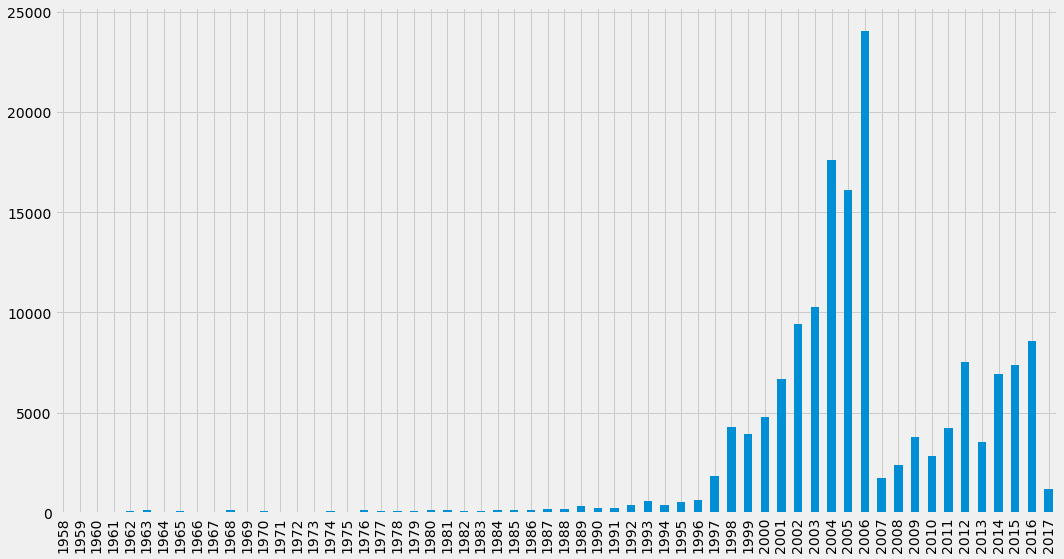

In [114]:
#Artık bir ortak yazar grafiği oluşturduğunuza göre, insanlar arasında oluşturulacak gelecekteki bağlantıları 
#(ilişkileri) tahmin etmenize izin verecek bir yaklaşıma ihtiyaç vardır. 
#Pagerank ve Kişileselleştirilmiş PageRank Algoritmalarına göre puan hesaplamaları yapılacaktır.
#Bu puanlara iki düğüm arasındaki bağlantı puanına dayalı olarak bir eşik değeri belirlenir. Buna göre tahmin yapılabilir.
#Ya da bir denetimli makine öğrenimi kullanılabilir. 
#Makine öğrenimi yöntemini kullanmak için graph datasetin eğitim ve test olarak ayrılması gerekmektedir.
#Ancak grafik veri setleri aralarındaki bağlantıdan dolayı rastgele şekilde eğitim ve test olarak bölünümez.
#Bu durum bilgi sızıntısına yol açar. Bağlantılardan kaynaklı olarak test veri seti eğitim veri seti olarak kullanılabilir.
#Bu nedenle dataset eğitim setine bölünür ve test seti olarak alt grafikler kullanılabilir. 
#Eğer eğitim setinde bir zaman kavramı varsa; belirlenen zamandan önceki veriler eğitim seti sonraki veriler test seti
#olarak ayrılabilir. 
#Ancak bu durumda eğitim ve test verilerinin genel ağ yapısının benzer olduğundan emin olunmalıdır. 
#Eğitim ve test setlerini oluşturmak amacıyla belirlenecek yıl ortak yazarların birlikte çalıştıkları yılların
#dağılımı incelenir.

query = """
MATCH p=()-[r:CO_AUTHOR]->() 
WITH r.year AS year, count(*) AS count
ORDER BY year
RETURN toString(year) AS year, count
"""
by_year = graph.run(query).to_data_frame()

ax = by_year.plot(kind='bar', x='year', y='count', legend=None, figsize=(15,8))
ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()

In [116]:
#Yukarıdaki grafiğe göre 2006 yılı veri setini bölmek için uygun bir yıl. Buna göre 2006 yılı öncesindeki veriler
#Eğitim verisi, sonrasındaki verler test verisi olarak alınabilir. 
#2006 yılına göre grafikte açık CO_AUTHOR_EARLY ve CO_AUTHOR_LATE ilişkileri oluşturulur.

query = """
MATCH (a)-[r:CO_AUTHOR]->(b) 
where r.year < 2006
MERGE (a)-[:CO_AUTHOR_EARLY {year: r.year}]-(b);
"""

graph.run(query).stats()

constraints_added: 0
constraints_removed: 0
contained_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 81096
relationships_created: 81096
relationships_deleted: 0

In [117]:
query = """
MATCH (a)-[r:CO_AUTHOR]->(b) 
where r.year >= 2006
MERGE (a)-[:CO_AUTHOR_LATE {year: r.year}]-(b);
"""

graph.run(query).stats()

constraints_added: 0
constraints_removed: 0
contained_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 74128
relationships_created: 74128
relationships_deleted: 0

In [118]:
#Bu alt grafiklerin her birinde kaç ortak yazar ilişkisinin olduğunu belirlenir:
#Eğitim verisi için:
query = """
MATCH ()-[:CO_AUTHOR_EARLY]->()
RETURN count(*) AS count
"""

graph.run(query).to_data_frame()

,count
0,81096


In [119]:
#Test verisi için:
query = """
MATCH ()-[:CO_AUTHOR_LATE]->()
RETURN count(*) AS count
"""

graph.run(query).to_data_frame()

,count
0,74128


In [120]:
#Negatif örnekler oluşturulur: Max. olumsuz örnekler = (# düğüm)² - (# ilişki) - (# düğüm)
#Çok yüksek doğruluklar elde etmeyi önlemek için bu olumsuz örneklerin grafik veri setinde azaltılması gerekir.
#Ya olumsuz örnekler aşağı çekilir. Ya da olumlu örnekler yukarı çekilir. 

def down_sample(df):
    copy = df.copy()
    zero = Counter(copy.label.values)[0]
    un = Counter(copy.label.values)[1]
    n = zero - un
    copy = copy.drop(copy[copy.label == 0].sample(n=n, random_state=1).index)
    return copy.sample(frac=1)

In [121]:
#Eğitim Test Verisinin ayrılması, Olumsuz örnekleri azaltmak amacıyla daha önce birlikte çalışılmış çalışmalar dışarda
#kalacak çekilde, iki veya üç düğüm uzaklıktaki kişiler alınarak azaltılmıştır.
train_existing_links = graph.run("""
MATCH (author:Author)-[:CO_AUTHOR_EARLY]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

train_missing_links = graph.run("""
MATCH (author:Author)
WHERE (author)-[:CO_AUTHOR_EARLY]-()
MATCH (author)-[:CO_AUTHOR_EARLY*2..3]-(other)
WHERE not((author)-[:CO_AUTHOR_EARLY]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()
train_missing_links = train_missing_links.drop_duplicates()

In [123]:
training_df = train_missing_links.append(train_existing_links, ignore_index=True)
training_df['label'] = training_df['label'].astype('category')
training_df = down_sample(training_df)

In [124]:
training_df.head()

,node1,node2,label
1027321,27295,165813,1
722860,161660,43363,0
12726,1353,134281,0
154719,20386,3148,0
107615,12033,139797,0


In [125]:
test_existing_links = graph.run("""
MATCH (author:Author)-[:CO_AUTHOR_LATE]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

test_missing_links = graph.run("""
MATCH (author:Author)
WHERE (author)-[:CO_AUTHOR_LATE]-()
MATCH (author)-[:CO_AUTHOR_LATE*2..3]-(other)
WHERE not((author)-[:CO_AUTHOR_LATE]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()
test_missing_links = test_missing_links.drop_duplicates()

In [126]:
test_df = test_missing_links.append(test_existing_links, ignore_index=True)
test_df['label'] = test_df['label'].astype('category')
test_df = down_sample(test_df)

In [127]:
test_df.head()

,node1,node2,label
367424,102371,102371,0
586704,151342,151342,0
1330237,248515,248516,1
412138,123056,123056,0
1335374,258177,258179,1


In [169]:
classifier = RandomForestClassifier(n_estimators=30, max_depth=10, random_state=0)
classifier1 = KNeighborsClassifier(n_neighbors=3)



In [129]:
def apply_graphy_features(data, rel_type):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
           pair.node2 AS node2,
           gds.alpha.linkprediction.commonNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS cn,
           gds.alpha.linkprediction.preferentialAttachment(
               p1, p2, {relationshipQuery: $relType}) AS pa,
           gds.alpha.linkprediction.totalNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS tn
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    features = graph.run(query, {"pairs": pairs, "relType": rel_type}).to_data_frame()
    return pd.merge(data, features, on = ["node1", "node2"])

In [130]:
training_df = apply_graphy_features(training_df, "CO_AUTHOR_EARLY")

In [131]:
training_df.head()

,node1,node2,label,cn,pa,tn
0,27295,165813,1,2.000,39.000,14.000
1,161660,43363,0,0.000,21.000,10.000
2,1353,134281,0,0.000,20.000,12.000
3,20386,3148,0,1.000,63.000,23.000
4,12033,139797,0,0.000,4.000,4.000


In [132]:
test_df = apply_graphy_features(test_df, "CO_AUTHOR")

In [133]:
test_df.head()

,node1,node2,label,cn,pa,tn
0,102371,102371,0,0.000,9.000,3.000
1,151342,151342,0,0.000,9.000,3.000
2,248515,248516,1,5.000,36.000,7.000
3,123056,123056,0,0.000,16.000,4.000
4,258177,258179,1,2.000,9.000,4.000


In [148]:
columns = ["cn"]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

RandomForestClassifier(max_depth=10, n_estimators=30, random_state=0)

In [149]:
def evaluate_model(predictions, actual):
    return pd.DataFrame({
        "Measure": ["Accuracy", "Precision", "Recall"],
        "Score": [accuracy_score(actual, predictions), 
                  precision_score(actual, predictions), 
                  recall_score(actual, predictions)]
    })

def feature_importance(columns, classifier):        
    display("Feature Importance")
    df = pd.DataFrame({
        "Feature": columns,
        "Importance": classifier.feature_importances_
    })
    df = df.sort_values("Importance", ascending=False)    
    ax = df.plot(kind='bar', x='Feature', y='Importance', legend=None)
    ax.xaxis.set_label_text("")
    plt.tight_layout()
    plt.show()

,Measure,Score
0,Accuracy,0.854
1,Precision,0.944
2,Recall,0.753


'Feature Importance'

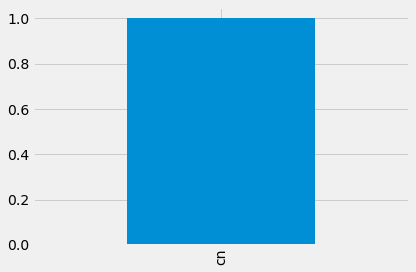

In [150]:
#RandomForrest
predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))
feature_importance(columns, classifier)

,Measure,Score
0,Accuracy,0.919
1,Precision,0.920
2,Recall,0.916


'Feature Importance'

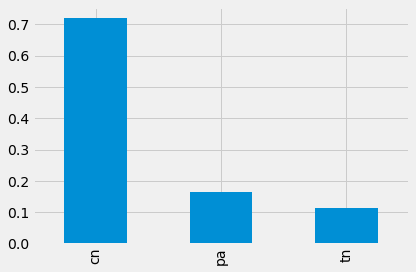

In [151]:
#RandomForrest
columns = ["cn", "pa", "tn"]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))
feature_importance(columns, classifier)

In [152]:
#K-NN
columns = ["cn"]

X = training_df[columns]
y = training_df["label"]
classifier1.fit(X, y)

KNeighborsClassifier(n_neighbors=3)

In [153]:
#K-NN
predictions = classifier1.predict(test_df[columns])
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))

,Measure,Score
0,Accuracy,0.831
1,Precision,0.773
2,Recall,0.939


In [154]:
#K-NN
columns = ["cn", "pa", "tn"]

X = training_df[columns]
y = training_df["label"]
classifier1.fit(X, y)

predictions = classifier1.predict(test_df[columns])
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))

,Measure,Score
0,Accuracy,0.885
1,Precision,0.901
2,Recall,0.865


In [181]:
#XGB için model:
xgb = XGBClassifier(n_estimators=100)
columns = ["cn", "pa", "tn"]

X = training_df[columns]
y = training_df["label"]



In [183]:
xgb.fit(X, y)
predictions = xgb.predict(test_df[columns])
y_test = test_df["label"]

[20:37:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [184]:
acc_xgb = (predictions == y_test).sum().astype(float) / len(predictions)*100

In [185]:
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))

XGBoost's prediction accuracy is: 92.02


In [188]:
#Naive Bayes
gnb = GaussianNB()
columns = ["cn", "pa", "tn"]

X = training_df[columns]
y = training_df["label"]
gnb.fit(X, y)

GaussianNB()

In [189]:
predictions = gnb.predict(test_df[columns])
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))

,Measure,Score
0,Accuracy,0.830
1,Precision,0.899
2,Recall,0.743
